## Week 3: Transfer Learning

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras import optimizers, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
training_dataset_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip'
validation_dataset_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip'

training_dataset_zip_path = tf.keras.utils.get_file(cache_subdir='datasets/horse-or-human/training', 
                                                    origin=training_dataset_url, extract=False)
validation_dataset_zip_path = tf.keras.utils.get_file(cache_subdir='datasets/horse-or-human/validation',
                                                      origin=validation_dataset_url, extract=False)

In [3]:
# if os.path.exists(training_dataset_zip_path):
#     os.remove(training_dataset_zip_path)

# if os.path.exists(validation_dataset_zip_path):
#     os.remove(validation_dataset_zip_path)

In [4]:
train_dir = os.path.dirname(training_dataset_zip_path)
validation_dir = os.path.dirname(validation_dataset_zip_path)

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.")

There are 500 images of horses for training.
There are 527 images of humans for training.
There are 128 images of horses for validation.
There are 128 images of humans for validation.


In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(150, 150))

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    batch_size=32,
    image_size=(150, 150))

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
model_weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = tf.keras.utils.get_file(cache_subdir='models', origin=model_weights_url)

In [8]:
def create_pre_trained_model(local_weights_file):
    
    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                    include_top=False,
                                    weights=None)

    pre_trained_model.load_weights(local_weights_file)
    pre_trained_model.trainable = False

    return pre_trained_model

In [9]:
pre_trained_model = create_pre_trained_model(local_weights_file)

Last layer
```
avg_pool (GlobalAveragePooling2D)  (None, 2048)                                                                                                
predictions (Dense)            (None, 1000)
```

In [10]:
name_layer = 'mixed7'
idx_layer = [layer.name for layer in pre_trained_model.layers].index(name_layer)
print(f'{name_layer} layer is the number {idx_layer+1} with output_shape {pre_trained_model.layers[idx_layer].output_shape}')

# for layer in pre_trained_model.layers[:idx_layer+1]:
#     layer.trainable = False

mixed7 layer is the number 229 with output_shape (None, 7, 7, 768)


In [11]:
print(f'Num layers: {len(pre_trained_model.layers)}')
print(f'Num none trainable layers: {[layer.trainable for layer in pre_trained_model.layers].count(False)}')

Num layers: 311
Num none trainable layers: 311


In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    # layers.RandomTranslation(0, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [14]:
def create_final_model(pre_trained_model, last_output):
    
    inputs = layers.Input(shape=(150, 150, 3))
    # x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = pre_trained_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, x)

    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
last_output = pre_trained_model.output
model = create_final_model(pre_trained_model, last_output)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [17]:
callbacks = myCallback()

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 20,
                    verbose = 2)

Epoch 1/20
33/33 - 13s - loss: 0.6061 - accuracy: 0.6728 - val_loss: 0.3622 - val_accuracy: 0.8672 - 13s/epoch - 404ms/step
Epoch 2/20
33/33 - 3s - loss: 0.2699 - accuracy: 0.9182 - val_loss: 0.1969 - val_accuracy: 0.9727 - 3s/epoch - 89ms/step
Epoch 3/20
33/33 - 3s - loss: 0.1419 - accuracy: 0.9718 - val_loss: 0.1149 - val_accuracy: 0.9922 - 3s/epoch - 90ms/step
Epoch 4/20
33/33 - 3s - loss: 0.0824 - accuracy: 0.9844 - val_loss: 0.0703 - val_accuracy: 1.0000 - 3s/epoch - 89ms/step
Epoch 5/20
33/33 - 3s - loss: 0.0522 - accuracy: 0.9932 - val_loss: 0.0471 - val_accuracy: 1.0000 - 3s/epoch - 91ms/step
Epoch 6/20
33/33 - 3s - loss: 0.0365 - accuracy: 0.9942 - val_loss: 0.0325 - val_accuracy: 1.0000 - 3s/epoch - 89ms/step
Epoch 7/20
33/33 - 3s - loss: 0.0275 - accuracy: 0.9942 - val_loss: 0.0241 - val_accuracy: 1.0000 - 3s/epoch - 90ms/step
Epoch 8/20
33/33 - 3s - loss: 0.0218 - accuracy: 0.9951 - val_loss: 0.0191 - val_accuracy: 1.0000 - 3s/epoch - 90ms/step
Epoch 9/20
33/33 - 3s - loss:

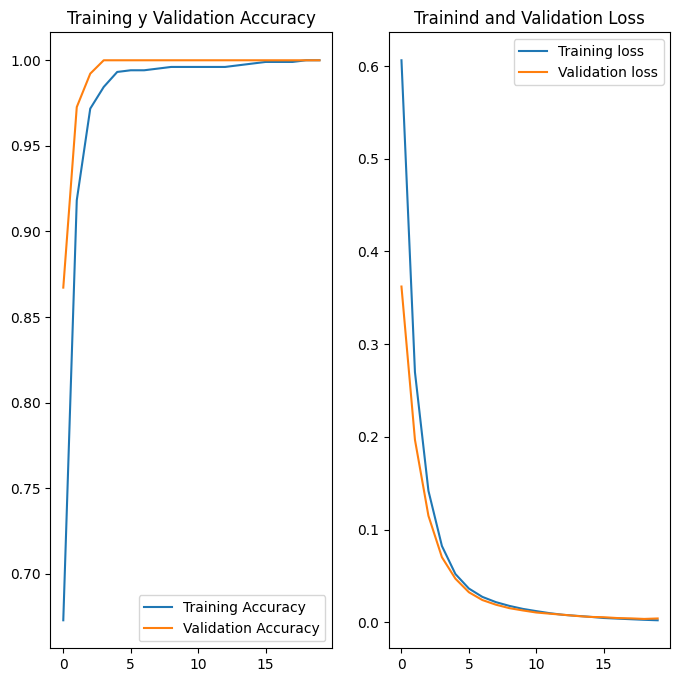

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()